In [5]:
!pip install shap lightgbm pandas numpy matplotlib > /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

In [6]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
df = pd.read_csv(url)
print(f"Shape: {df.shape}\nFirst 3 rows:\n{df.head(3)}")

Shape: (195, 24)
First 3 rows:
             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.06545  0.02211  21.033       1  0.414783  0.815285 -4.813031   
1      0.09403  0.01929  19.085       1  0.458359  0.819521 -4.075192   
2      0.08270  0.01309  20.651       1  0.429895  0.825288 -4.443179   

    spread2        D2       PPE  
0  0.266482  2.301442  0.284654 

In [13]:
import re

# Preprocess data
X = df.drop(['name', 'status'], axis=1)
# Replace non-alphanumeric characters in column names with underscores
X.columns = [re.sub(r'\W+', '_', col) for col in X.columns]
y = df['status']  # 1 = Parkinsons, 0 = Healthy

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [14]:
#Train model
model = LGBMClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

model.fit(X_train, y_train)
full_acc = model.score(X_test, y_test)


[LightGBM] [Info] Number of positive: 118, number of negative: 38
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1118
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.756410 -> initscore=1.133098
[LightGBM] [Info] Start training from score 1.133098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


SHAP plot successfully saved!


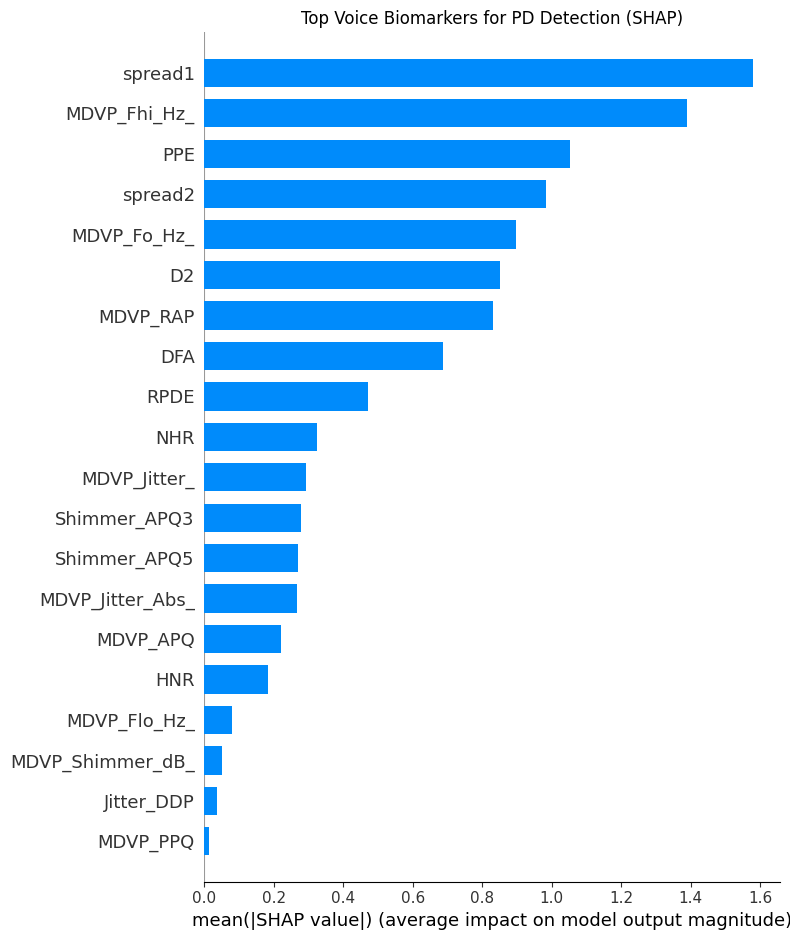

In [18]:
#SHAP Explainability Analysis)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

plt.figure(figsize=(10,6))

# For binary classification:
if len(shap_values) == 2:  # [healthy_shap, pd_shap]
    shap.summary_plot(
        shap_values[1],  # Use PD class SHAP values
        X_train,
        feature_names=X_train.columns,
        plot_type="bar",
        show=False
    )
else:  # For single output
    shap.summary_plot(
        shap_values,
        X_train,
        feature_names=X_train.columns,
        plot_type="bar",
        show=False
    )

plt.title("Top Voice Biomarkers for PD Detection (SHAP)")
plt.tight_layout()
plt.savefig("shap_feature_importance.png", dpi=300, bbox_inches='tight')
print("SHAP plot successfully saved!")

In [19]:
#Minimalist Model (Top 3 Features)

# Select top 3 features using ANOVA F-value
selector = SelectKBest(f_classif, k=3)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]


# Retrain with only top features
model_minimal = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    random_state=42
).fit(X_train[selected_features], y_train)

minimal_acc = model_minimal.score(X_test[selected_features], y_test)
print("Minimal Model Accuracy: {minimal_acc:.2%}")


[LightGBM] [Info] Number of positive: 118, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.756410 -> initscore=1.133098
[LightGBM] [Info] Start training from score 1.133098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [20]:
#Compare Performances
results = pd.DataFrame({
    'Model': ['Full Model', 'Minimal Model'],
    'Accuracy': [full_acc, minimal_acc],
    'Features Used': [X.shape[1], len(selected_features)]
})

print("Final Results:")
print(results.to_markdown(index=False))

Final Results:
| Model         |   Accuracy |   Features Used |
|:--------------|-----------:|----------------:|
| Full Model    |   0.923077 |              22 |
| Minimal Model |   0.846154 |               3 |
